
True Positives, False Positives, and False Negatives per VCF:

  5x  FASTQ: True Positives = 2609552, False Positives = 71684, False Negatives = 1281230
  5x  BAM: True Positives = 1943140, False Positives = 238634, False Negatives = 1947642
  10x  FASTQ: True Positives = 3412757, False Positives = 80063, False Negatives = 478025
  10x  BAM: True Positives = 2215418, False Positives = 114494, False Negatives = 1675364
  15x  FASTQ: True Positives = 3641359, False Positives = 83927, False Negatives = 249423
  15x  BAM: True Positives = 2478433, False Positives = 196362, False Negatives = 1412349
  20x  FASTQ: True Positives = 3725959, False Positives = 68109, False Negatives = 164823
  20x  BAM: True Positives = 3691752, False Positives = 244940, False Negatives = 199030
  36x  FASTQ: True Positives = 3815088, False Positives = 63438, False Negatives = 75694
  36x  BAM: True Positives = 3793781, False Positives = 622511, False Negatives = 97001
  5x  FASTQ: True Positives = 23095, Fals

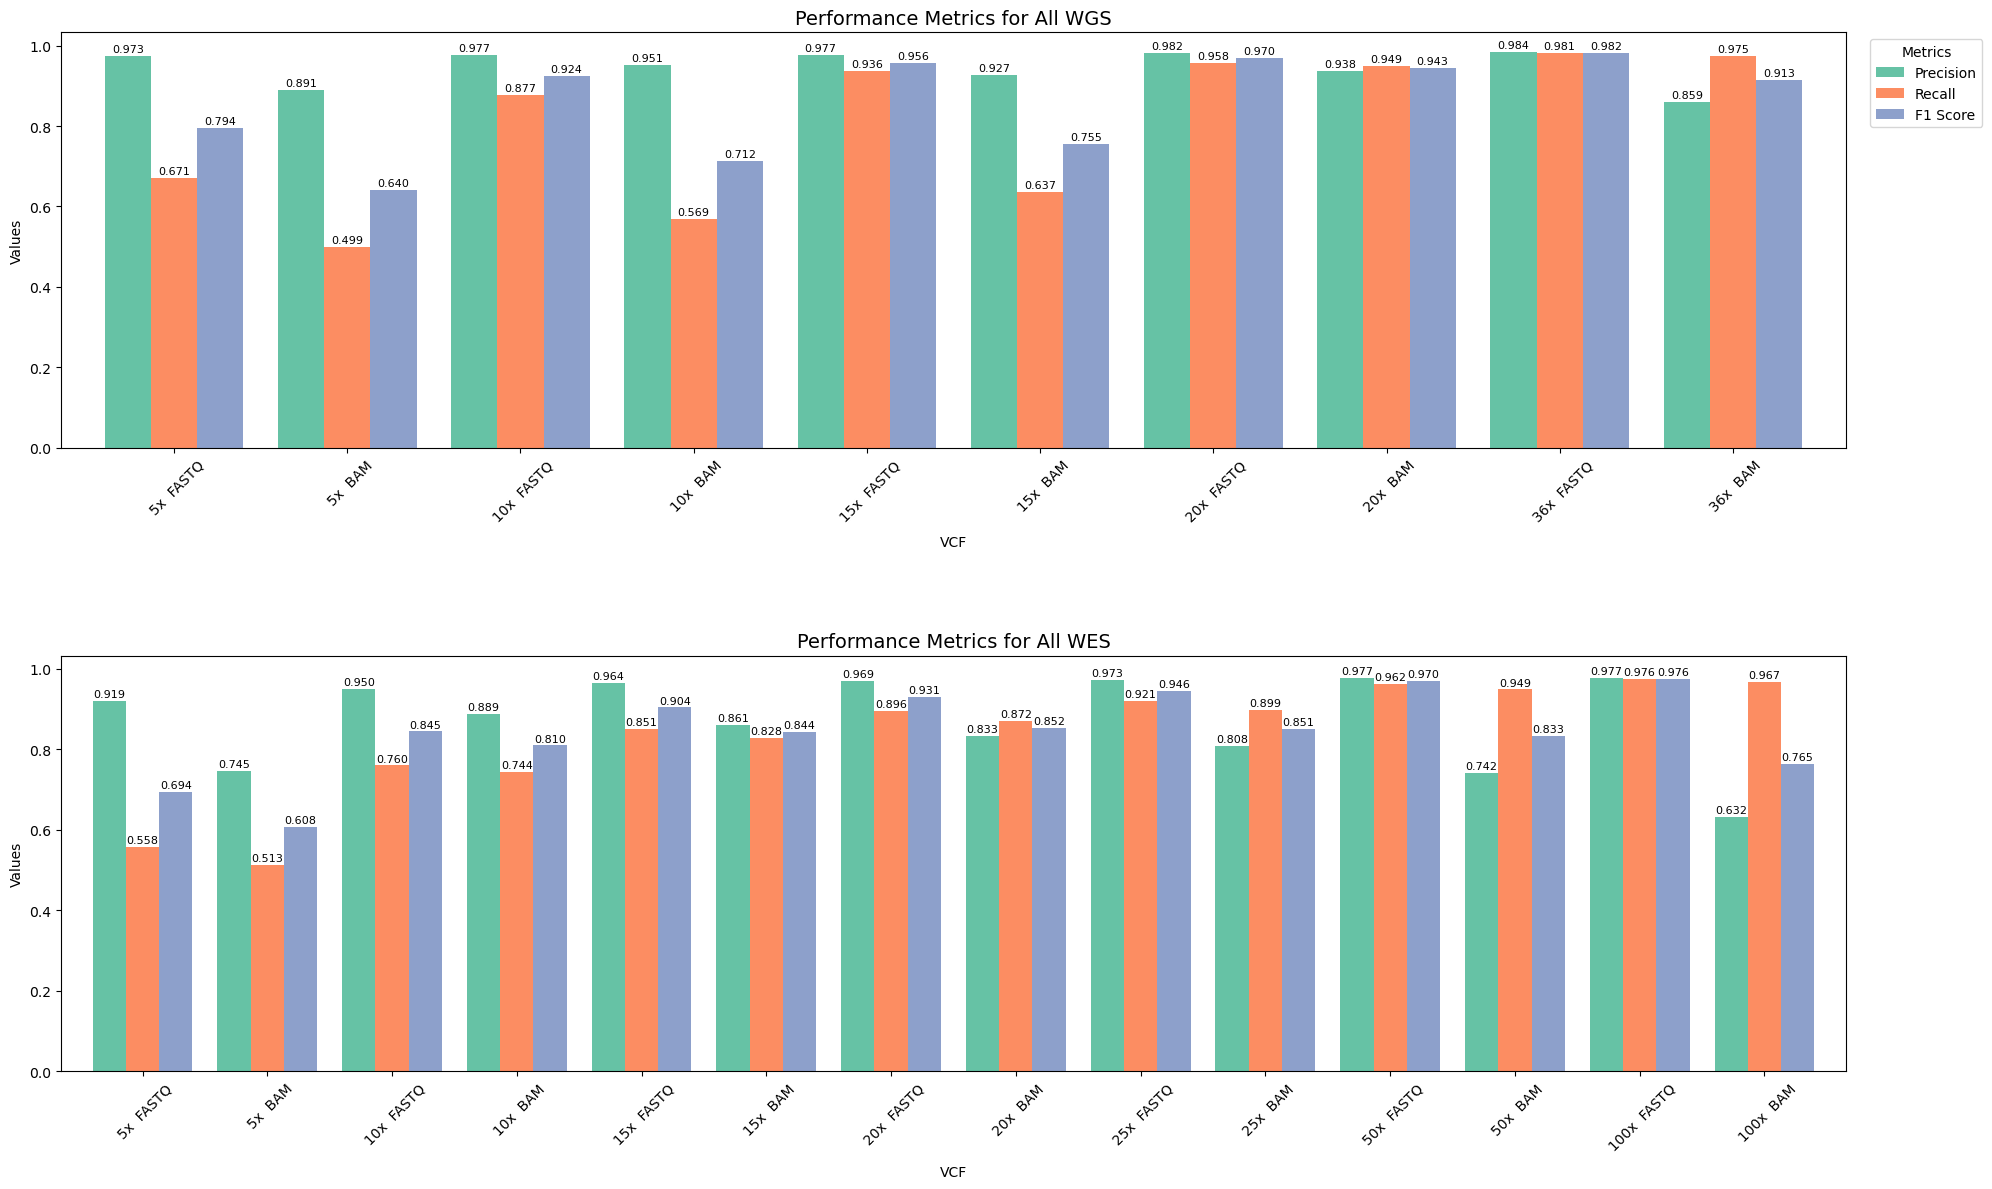

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import os

# Base directory for all VCF files
BASE_DIR = "All"

# Store reference files and sample VCFs for wgs and wes
datasets = {
    'wgs': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark.vcf',
        'vcf_files': [
            'wgs_5x_FASTQ.vcf', 'wgs_5x_BAM.vcf',
            'wgs_10x_FASTQ.vcf', 'wgs_10x_BAM.vcf',
            'wgs_15x_FASTQ.vcf', 'wgs_15x_BAM.vcf',
            'wgs_20x_FASTQ.vcf', 'wgs_20x_BAM.vcf',
            'wgs_36x_FASTQ.vcf', 'wgs_36x_BAM.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark.vcf'  # Will be removed from plot later
        ]
    },
    'wes': {
        'reference': 'wes_HG002_GRCh38_1_22_v4.2.1_benchmark.vcf',
        'vcf_files': [
            'wes_5x_FASTQ.vcf', 'wes_5x_BAM.vcf',
            'wes_10x_FASTQ.vcf', 'wes_10x_BAM.vcf',
            'wes_15x_FASTQ.vcf', 'wes_15x_BAM.vcf',
            'wes_20x_FASTQ.vcf', 'wes_20x_BAM.vcf',
            'wes_25x_FASTQ.vcf', 'wes_25x_BAM.vcf',
            'wes_50x_FASTQ.vcf', 'wes_50x_BAM.vcf',
            'wes_100x_FASTQ.vcf', 'wes_100x_BAM.vcf',
            'wes_HG002_GRCh38_1_22_v4.2.1_benchmark.vcf'  # Will be removed from plot later
        ]
    }
}

# Prepend BASE_DIR to all paths
for variant_type, data in datasets.items():
    data['reference'] = os.path.join(BASE_DIR, data['reference'])
    data['vcf_files'] = [os.path.join(BASE_DIR, f) for f in data['vcf_files']]

# Container for results
all_metrics = []

# Process both wgs and wes
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'True Positives': true_positive,
            'False Positives': false_positive,
            'False Negatives': false_negative,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return os.path.basename(filename).replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ').replace('snps', ' ')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_wgs = df[df['Type'] == 'wgs'].copy()
df_wes = df[df['Type'] == 'wes'].copy()

# Reset index for plotting
df_wgs.reset_index(drop=True, inplace=True)
df_wes.reset_index(drop=True, inplace=True)

# Show TP/FP/FN counts
print("\nTrue Positives, False Positives, and False Negatives per VCF:\n")
for _, row in df.iterrows():
    print(f"{row['VCF']}: True Positives = {row['True Positives']}, "
          f"False Positives = {row['False Positives']}, False Negatives = {row['False Negatives']}")

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# wgs plot
ax1 = df_wgs[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for All WGS', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# wes plot
ax2 = df_wes[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for All WES', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase spacing
plt.savefig("All.png", dpi=300)
plt.show()



True Positives, False Positives, and False Negatives per VCF:

  5x  FASTQ  : True Positives = 2331685, False Positives = 39459, False Negatives = 1034694
  5x  BAM  : True Positives = 1751759, False Positives = 208559, False Negatives = 1614620
  10x  FASTQ  : True Positives = 3026405, False Positives = 38188, False Negatives = 339974
  10x  BAM  : True Positives = 1972620, False Positives = 80570, False Negatives = 1393759
  15x  FASTQ  : True Positives = 3213504, False Positives = 41221, False Negatives = 152875
  15x  BAM  : True Positives = 2190943, False Positives = 126459, False Negatives = 1175436
  20x  FASTQ  : True Positives = 3277991, False Positives = 36318, False Negatives = 88388
  20x  BAM  : True Positives = 3252188, False Positives = 167905, False Negatives = 114191
  36x  FASTQ  : True Positives = 3337878, False Positives = 35733, False Negatives = 28501
  36x  BAM  : True Positives = 3324395, False Positives = 468011, False Negatives = 41984
  5x  FASTQ  : True Pos

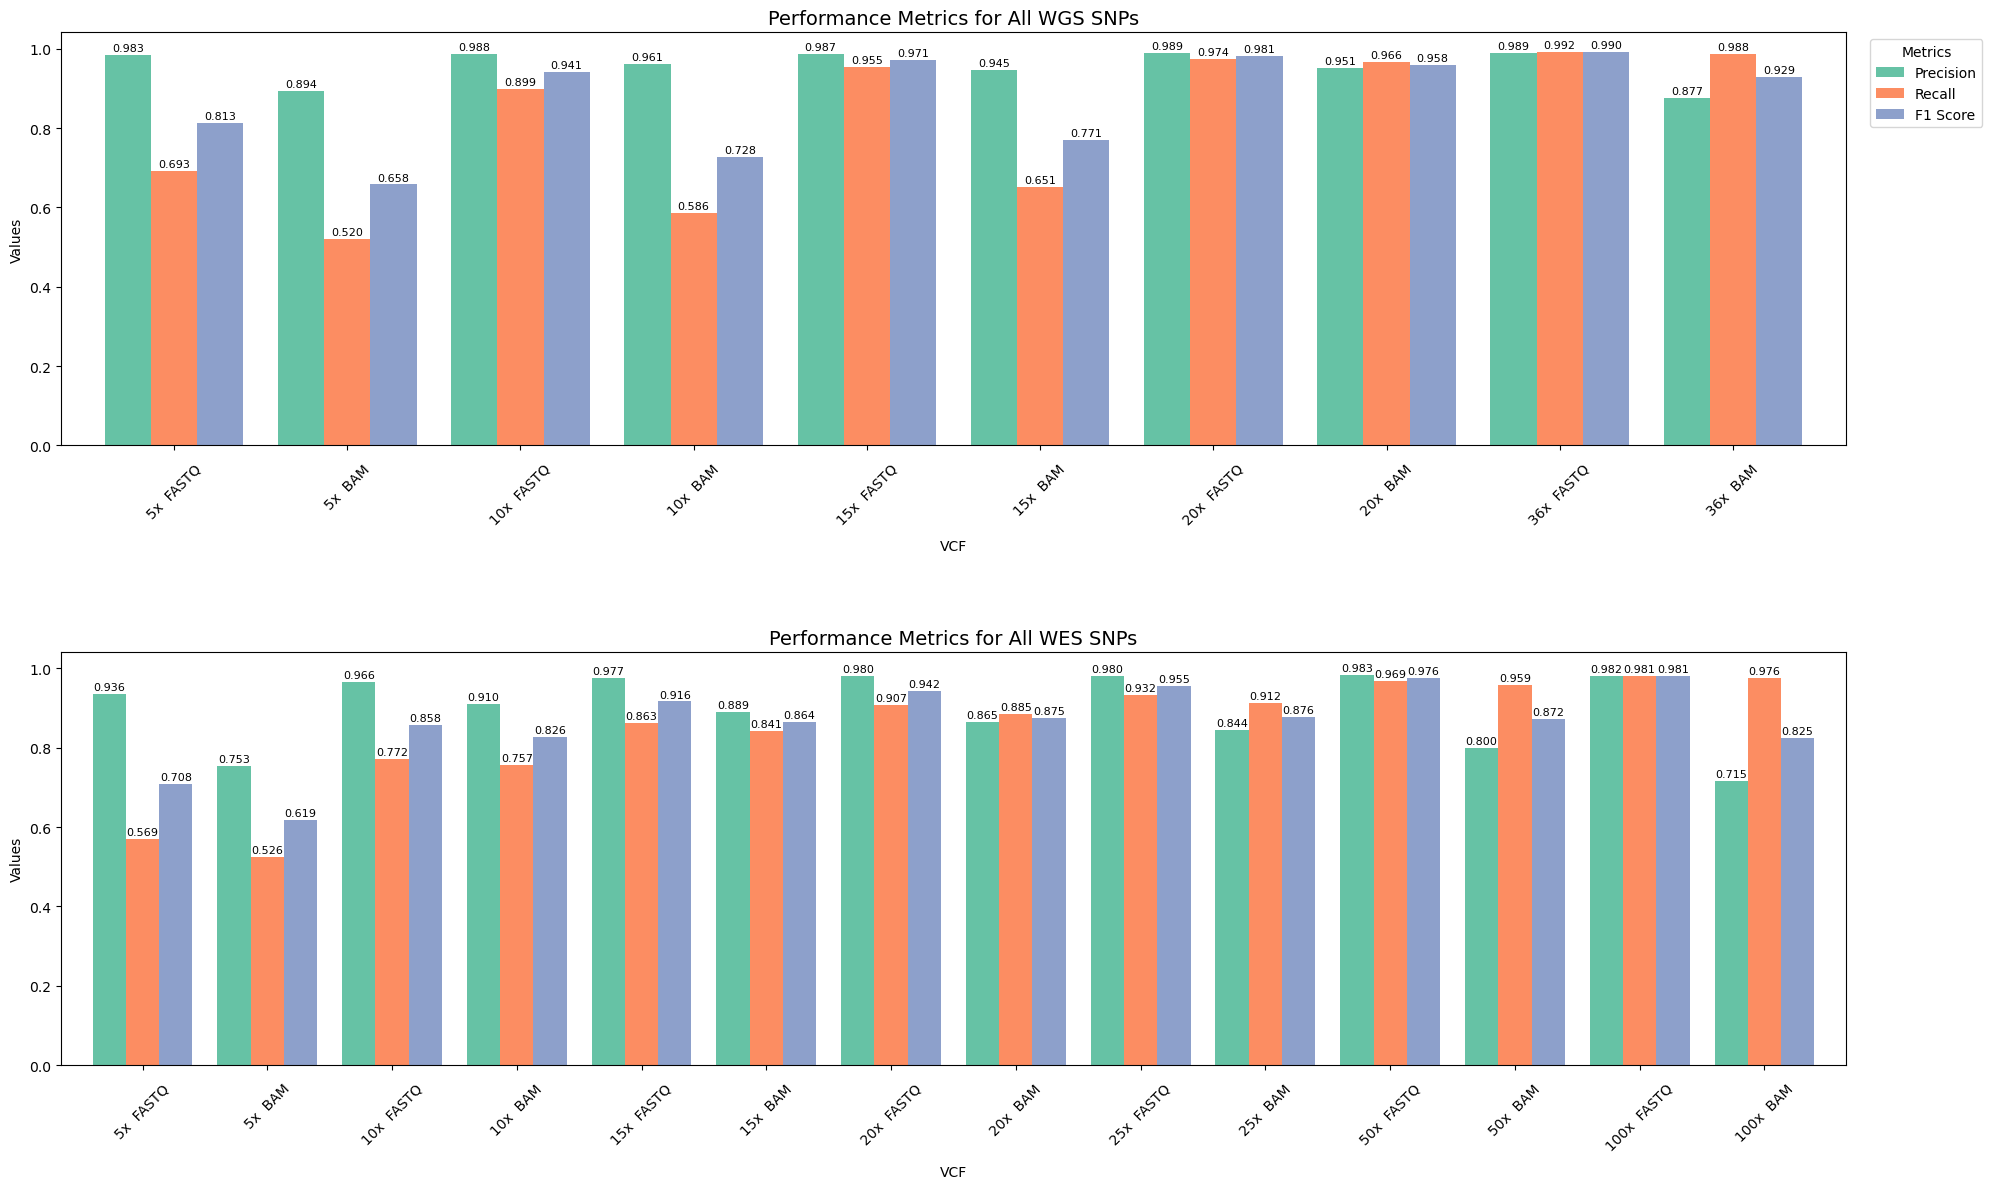

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import os

# Base directory for all VCF files
BASE_DIR = "All/snps"

# Store reference files and sample VCFs for wgs and wes
datasets = {
    'wgs': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_snps.vcf',
        'vcf_files': [
            'wgs_5x_FASTQ_snps.vcf', 'wgs_5x_BAM_snps.vcf',
            'wgs_10x_FASTQ_snps.vcf', 'wgs_10x_BAM_snps.vcf',
            'wgs_15x_FASTQ_snps.vcf', 'wgs_15x_BAM_snps.vcf',
            'wgs_20x_FASTQ_snps.vcf', 'wgs_20x_BAM_snps.vcf',
            'wgs_36x_FASTQ_snps.vcf', 'wgs_36x_BAM_snps.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_snps.vcf'  # Will be removed from plot later
        ]
    },
    'wes': {
        'reference': 'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_snps.vcf',
        'vcf_files': [
            'wes_5x_FASTQ_snps.vcf', 'wes_5x_BAM_snps.vcf',
            'wes_10x_FASTQ_snps.vcf', 'wes_10x_BAM_snps.vcf',
            'wes_15x_FASTQ_snps.vcf', 'wes_15x_BAM_snps.vcf',
            'wes_20x_FASTQ_snps.vcf', 'wes_20x_BAM_snps.vcf',
            'wes_25x_FASTQ_snps.vcf', 'wes_25x_BAM_snps.vcf',
            'wes_50x_FASTQ_snps.vcf', 'wes_50x_BAM_snps.vcf',
            'wes_100x_FASTQ_snps.vcf', 'wes_100x_BAM_snps.vcf',
            'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_snps.vcf'  # Will be removed from plot later
        ]
    }
}

# Prepend BASE_DIR to all paths
for variant_type, data in datasets.items():
    data['reference'] = os.path.join(BASE_DIR, data['reference'])
    data['vcf_files'] = [os.path.join(BASE_DIR, f) for f in data['vcf_files']]

# Container for results
all_metrics = []

# Process both wgs and wes
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'True Positives': true_positive,
            'False Positives': false_positive,
            'False Negatives': false_negative,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return os.path.basename(filename).replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ').replace('snps', ' ')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_wgs = df[df['Type'] == 'wgs'].copy()
df_wes = df[df['Type'] == 'wes'].copy()

# Reset index for plotting
df_wgs.reset_index(drop=True, inplace=True)
df_wes.reset_index(drop=True, inplace=True)

# Show TP/FP/FN counts
print("\nTrue Positives, False Positives, and False Negatives per VCF:\n")
for _, row in df.iterrows():
    print(f"{row['VCF']}: True Positives = {row['True Positives']}, "
          f"False Positives = {row['False Positives']}, False Negatives = {row['False Negatives']}")

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# wgs plot
ax1 = df_wgs[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for All WGS SNPs', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# wes plot
ax2 = df_wes[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for All WES SNPs', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase spacing
plt.savefig("All_SNPs.png", dpi=300)
plt.show()



True Positives, False Positives, and False Negatives per VCF:

  5x  FASTQ  : True Positives = 277934, False Positives = 32357, False Negatives = 247721
  5x  BAM  : True Positives = 191408, False Positives = 30155, False Negatives = 334247
  10x  FASTQ  : True Positives = 386577, False Positives = 42180, False Negatives = 139078
  10x  BAM  : True Positives = 242930, False Positives = 34120, False Negatives = 282725
  15x  FASTQ  : True Positives = 428172, False Positives = 43169, False Negatives = 97483
  15x  BAM  : True Positives = 287683, False Positives = 70219, False Negatives = 237972
  20x  FASTQ  : True Positives = 448343, False Positives = 32335, False Negatives = 77312
  20x  BAM  : True Positives = 439921, False Positives = 77602, False Negatives = 85734
  36x  FASTQ  : True Positives = 477678, False Positives = 28361, False Negatives = 47977
  36x  BAM  : True Positives = 469823, False Positives = 155327, False Negatives = 55832
  5x  FASTQ  : True Positives = 1228, Fals

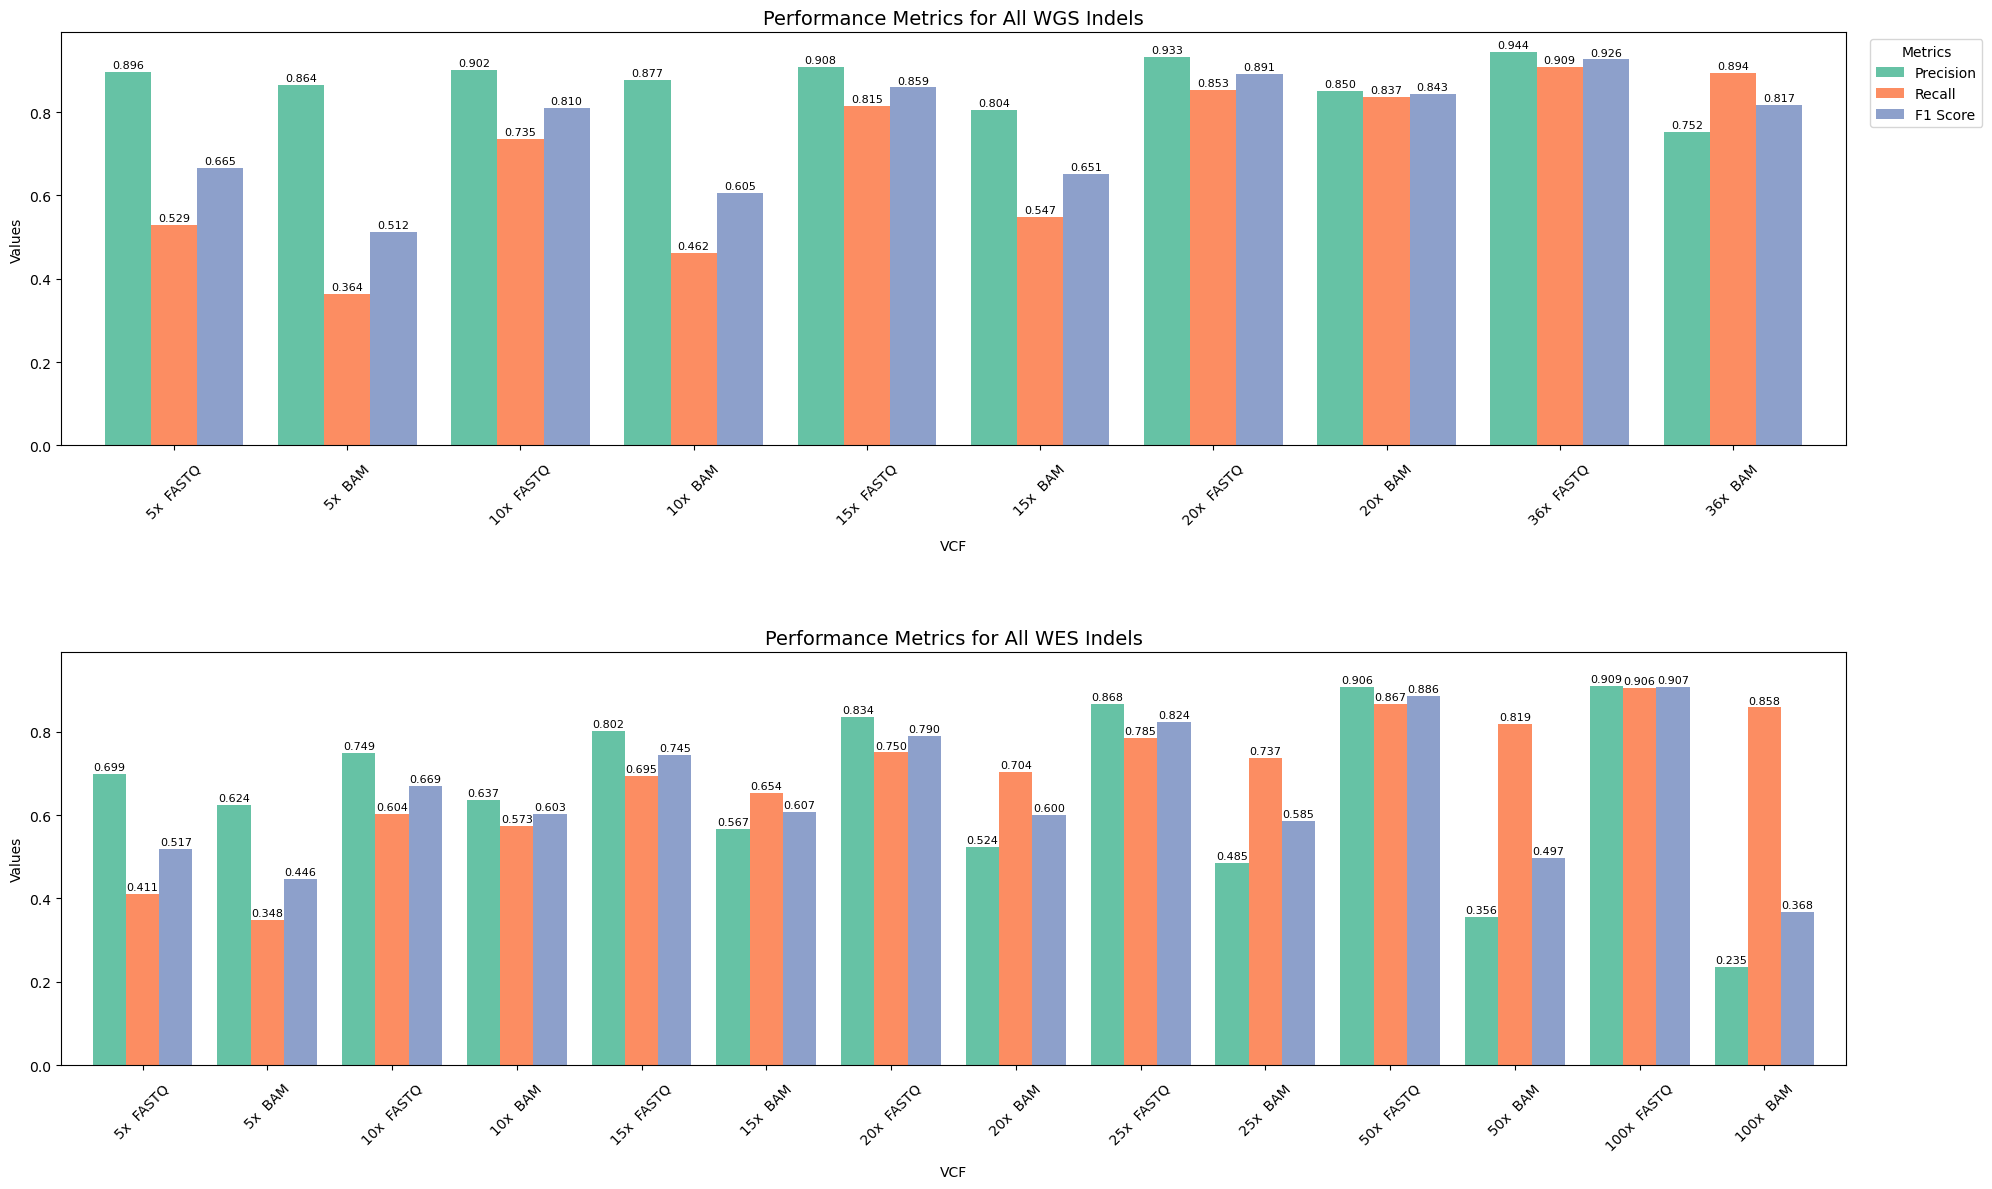

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import os

# Base directory for all VCF files
BASE_DIR = "All/indels"

# Store reference files and sample VCFs for wgs and wes
datasets = {
    'wgs': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_indels.vcf',
        'vcf_files': [
            'wgs_5x_FASTQ_indels.vcf', 'wgs_5x_BAM_indels.vcf',
            'wgs_10x_FASTQ_indels.vcf', 'wgs_10x_BAM_indels.vcf',
            'wgs_15x_FASTQ_indels.vcf', 'wgs_15x_BAM_indels.vcf',
            'wgs_20x_FASTQ_indels.vcf', 'wgs_20x_BAM_indels.vcf',
            'wgs_36x_FASTQ_indels.vcf', 'wgs_36x_BAM_indels.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_indels.vcf'  # Will be removed from plot later
        ]
    },
    'wes': {
        'reference': 'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_indels.vcf',
        'vcf_files': [
            'wes_5x_FASTQ_indels.vcf', 'wes_5x_BAM_indels.vcf',
            'wes_10x_FASTQ_indels.vcf', 'wes_10x_BAM_indels.vcf',
            'wes_15x_FASTQ_indels.vcf', 'wes_15x_BAM_indels.vcf',
            'wes_20x_FASTQ_indels.vcf', 'wes_20x_BAM_indels.vcf',
            'wes_25x_FASTQ_indels.vcf', 'wes_25x_BAM_indels.vcf',
            'wes_50x_FASTQ_indels.vcf', 'wes_50x_BAM_indels.vcf',
            'wes_100x_FASTQ_indels.vcf', 'wes_100x_BAM_indels.vcf',
            'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_indels.vcf'  # Will be removed from plot later
        ]
    }
}

# Prepend BASE_DIR to all paths
for variant_type, data in datasets.items():
    data['reference'] = os.path.join(BASE_DIR, data['reference'])
    data['vcf_files'] = [os.path.join(BASE_DIR, f) for f in data['vcf_files']]

# Container for results
all_metrics = []

# Process both wgs and wes
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'True Positives': true_positive,
            'False Positives': false_positive,
            'False Negatives': false_negative,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return os.path.basename(filename).replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ').replace('indels', ' ')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_wgs = df[df['Type'] == 'wgs'].copy()
df_wes = df[df['Type'] == 'wes'].copy()

# Reset index for plotting
df_wgs.reset_index(drop=True, inplace=True)
df_wes.reset_index(drop=True, inplace=True)

# Show TP/FP/FN counts
print("\nTrue Positives, False Positives, and False Negatives per VCF:\n")
for _, row in df.iterrows():
    print(f"{row['VCF']}: True Positives = {row['True Positives']}, "
          f"False Positives = {row['False Positives']}, False Negatives = {row['False Negatives']}")

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# wgs plot
ax1 = df_wgs[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for All WGS Indels', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# wes plot
ax2 = df_wes[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for All WES Indels', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase spacing
plt.savefig("All_indels.png", dpi=300)
plt.show()
